In [1]:
%run stdPackages.ipynb

Load database:

In [ ]:
with open (f"{d['data']}\\Main_data", "rb") as file:
    db = pickle.load(file)
db['MWP_LoadShedding_E'] = 100
db['MWP_LoadShedding_H'] = 100
db['GeneratingCap_H'].loc['g1_SH'] = 25
db['FuelPrice'].loc['BioMass'] = 25.2
db_ini = db.copy()

Ancilliary sets used to access g1 area

In [3]:
ids = db['id'][db['id'].str.startswith('g1')]
g   = pd.Index(['g1'],name='g')
hvts= db['hvt'][db['hvt'].str.startswith('g1')]
cE  = pd.Index(['Consumer 1'],name='c_E')
cH  = pd.Index(['Consumer 1'],name='c_H')

Initialize model and solve the model:

In [4]:
m = mBasicPH.mSimple(db)
m.solve()

Solution status 0: Optimization terminated successfully. (HiGHS Status 7: Optimal)


*Write to excel data:*

In [5]:
v = db['CapVariation'].unstack('hvt')
v.index = pd.MultiIndex.from_tuples(v.index.values).rename(['month','hour'])
v.reset_index().sort_values(by=['month','hour']).to_excel(os.getcwd()+'\\test.xlsx')

In [6]:
v = db['LoadVariation_E'].xs('Consumer 1',level='c_E') * db['Load_E'].xs('Consumer 1')
v.index = pd.MultiIndex.from_tuples(v.index.values).rename(['month','hour'])
v.reset_index().sort_values(by=['month','hour']).to_excel(os.getcwd()+'\\test2.xlsx')

In [7]:
v = db['LoadVariation_H'].xs('Consumer 1',level='c_H') * db['Load_H'].xs('Consumer 1')
v.index = pd.MultiIndex.from_tuples(v.index.values).rename(['month','hour'])
v.reset_index().sort_values(by=['month','hour']).to_excel(os.getcwd()+'\\test3.xlsx')

## 1. Desriptive plots, baseline scenario

### 1.1. Load duration/residual demand curve

In [8]:
genCap_E = rc_pd(applyMult(m.hourlyGeneratingCap_E, m.db['id2hvt']), ('not', pd.Index(['Standard'], name = 'hvt'))).droplevel('id').rename_axis(index={'hvt':'id'})
genCap_H = rc_pd(applyMult(m.hourlyGeneratingCap_H, m.db['id2hvt']), ('not', pd.Index(['Standard'], name = 'hvt'))).droplevel('id').rename_axis(index={'hvt':'id'})

Load duration curve (LDC) and residual demand curve (RDC) - for electricity:

In [9]:
LDC = m.hourlyLoad_E.xs('g1',level='g').sort_values(ascending=False)
LDC.index = [i/(len(LDC)) for i in range(1, len(LDC)+1)]
LDC.at[0] = LDC.iloc[0]
LDC = LDC.sort_index()
RDC = (m.hourlyLoad_E.xs('g1',level='g')-pdSum(genCap_E,'id')).sort_values(ascending = False)
RDC.index = [i/(len(RDC)) for i in range(1, len(RDC)+1)]
RDC.at[0] = RDC.iloc[0]
RDC = RDC.sort_index()

Load duration curve (LDC) and residual demand curve (RDC) - for heat:

In [10]:
LDC_H = m.hourlyLoad_H.xs('g1',level='g').sort_values(ascending=False)
LDC_H.index = [i/(len(LDC_H)) for i in range(1, len(LDC_H)+1)]
LDC_H.at[0] = LDC_H.iloc[0]
LDC_H = LDC_H.sort_index()
RDC_H = (m.hourlyLoad_H.xs('g1',level='g')-pdSum(genCap_H,'id')).sort_values(ascending = False)
RDC_H.index = [i/(len(RDC_H)) for i in range(1, len(RDC_H)+1)]
RDC_H.at[0] = RDC_H.iloc[0]
RDC_H = RDC_H.sort_index()

Plot graph and save:

In [11]:
%%capture
mult_graphs()
nplots = 2
nrows = math.ceil(nplots/2)
fig, axes = plt.subplots(nrows, min(nplots, 2), figsize = (14, (8*nrows)));
plt.subplots_adjust(hspace=0.35)
# Plot 1:
ax = plt.subplot(nrows, min(nplots,2), 1)
ax.set_title('Electricity')
df = pd.DataFrame({'Load duration curve': LDC, 'Residual demand curve': RDC})
seaborn.lineplot(data = df,
                 ax = ax, linewidth = 3, legend = False);
ax.set_ylabel('MWh', labelpad=10);
ax.set_ylim([0, 160]);
ax.set_xlim([0,1]);
ax.set_xlabel('Capacity factor', labelpad =10);

# Plot 1:
ax = plt.subplot(nrows, min(nplots,2), 2)
ax.set_title('Heat')
seaborn.lineplot(data = pd.DataFrame({'Load duration curve': LDC_H, 'Residual demand curve': RDC_H}),
                 ax = ax, linewidth = 3, legend = False);
ax.set_ylabel('MWh', labelpad=10);
ax.set_ylim([0, 275]);
ax.set_xlim([0,1]);
ax.set_xlabel('Capacity factor', labelpad =10);


fig.legend(df.columns,loc=9,ncol=2,frameon=True)
fig.tight_layout();
fig.subplots_adjust(top=0.88);
fig.savefig(f"{d['figs']}\\Q3_LDC.pdf", edgecolor='k')

### 1.2. Price variation

In [12]:
p = pd.DataFrame({'$p_E$': m.db['marginalSystemCosts_E'].xs('g1'), '$p_H$': m.db['marginalSystemCosts_H'].xs('g1')})

In [13]:
%%capture
mult_graphs()
nplots = 2
nrows = math.ceil(nplots/2)
fig, axes = plt.subplots(nrows, min(nplots, 2), figsize = (14, (8*nrows)));
plt.subplots_adjust(hspace=0.35)
# Plot 1:
ax = plt.subplot(nrows, min(nplots,2), 1)
ax.set_title('Electricity')
seaborn.lineplot(data = m.db['marginalSystemCosts_E'].xs('g1').sort_values(ascending=False).reset_index(drop=True),
                 ax = ax, linewidth = 3);
ax.set_ylabel('€/MWh', labelpad=10);
ax.set_xlabel('Hours', labelpad =10);
ax.set_xlim([0,288]);
ax.set_ylim([0,110]);

# Plot 2:
ax = plt.subplot(nrows, min(nplots,2), 2)
ax.set_title('Heat')
seaborn.lineplot(data = m.db['marginalSystemCosts_H'].xs('g1').sort_values(ascending=False).reset_index(drop=True),
                 ax = ax, linewidth = 3);
ax.set_ylabel('€/MWh', labelpad=10);
ax.set_xlabel('Hours', labelpad =10);
ax.set_xlim([0,288]);
ax.set_ylim([0,110]);

fig.tight_layout();
fig.savefig(f"{d['figs']}\\Q3_sortedPrices.pdf", edgecolor='k')

### 1.3. Average energy and capacity costs

Plot average capacity costs and energy costs against marginal costs:

In [14]:
cap = pd.concat([applyMult(m.db['GeneratingCap_H'], m.db['id2g']).xs('g1',level='g'), applyMult(m.db['GeneratingCap_E'], m.db['id2g']).xs('g1',level='g')])
gen = pd.concat([rc_pd(m.db['Generation_E'].xs('g1').add(m.db['Generation_H'].xs('g1'), fill_value=0), ('not', pd.Index(['g1_HP'],name='id'))),
                 rc_pd(m.db['Generation_H'].xs('g1'), pd.Index(['g1_HP'],name='id'))])
fcosts = 1000 * rc_pd(m.db['FOM'],ids) * cap * len(m.db['h'])/8760
vcosts = rc_pd(m.db['mc'], ids) * pdSum(gen,'h')
hp_elecCosts = pdSum(rc_pd(-m.db['Generation_E'].xs('g1',level='g'), pd.Index(['g1_HP'],name='id')) * m.db['marginalSystemCosts_E'].xs('g1'), 'h')
vcosts = vcosts.add(hp_elecCosts,fill_value=0)
fcosts_ACC = fcosts / cap
vcosts_ACC = vcosts / cap
fcosts_AEC = fcosts / pdSum(gen,'h')
vcosts_ACC = vcosts / cap
vcosts_AEC = vcosts / pdSum(gen,'h')

In [15]:
df = pd.concat({('Variable','Average capacity costs'): vcosts_ACC,
                ('Fixed', 'Average capacity costs'): fcosts_ACC,
                ('Variable','Average energy costs'): vcosts_AEC,
                ('Fixed', 'Average energy costs'): fcosts_AEC,
                ('', 'Marginal costs'): rc_pd(m.db['mc'],ids)}, names = ['type','variable']).unstack(['variable','type'])
df.index = df.index.map(lambda x: x.strip('g1_'))

In [16]:
%%capture
mult_graphs()
nplots = 2
nrows = math.ceil(nplots/2)
fig, axes = plt.subplots(nrows, min(nplots, 2), figsize = (14, (8*nrows)));
plt.subplots_adjust(hspace=0.35)
# Plot 1:
ax = plt.subplot(nrows, min(nplots,2), 1)
df_i = df['Average capacity costs'].assign(total = lambda x: x.Variable+x.Fixed).sort_values(by='total')[['Variable','Fixed']]
df_i.plot.bar(ax=ax, stacked=True, legend=False)
ax.set_xlabel('$i$', labelpad=10);
ax.set_ylabel("Average capacity costs, €", labelpad=10);
ax.set_yticks(np.linspace(0, 15000, 6))
ax.set_ylim([0, 15000]);

# Plot 2: Zooming in
ax = plt.subplot(nrows, min(nplots,2), 2)
df_i = df['Average energy costs'].assign(total = lambda x: x.Variable+x.Fixed).sort_values(by='total')[['Variable','Fixed']]
df_i.plot.bar(ax=ax, stacked=True, legend=False)
# df['Average energy costs'].plot.bar(ax=ax, stacked=True, legend=False);
ax.set_xlabel('$i$', labelpad=10);
ax.set_ylabel("Average energy costs, €",labelpad=10);
ax.set_yticks(np.linspace(0, 60, 6))
ax.set_ylim([0, 60]);

fig.legend(df['Average energy costs'].columns,loc=9,ncol=3,frameon=True)
fig.tight_layout();
fig.subplots_adjust(top=0.88);
fig.savefig(f"{d['figs']}\\Q3_CostDecomposition.pdf", edgecolor='k')

#### 1.4. Capacity factors and marginal costs

In [17]:
subsetIdsTech = mBasicPH.subsetIdsTech
PCF = rc_pd(m.db['PCF'],ids).sort_values()
PCF.index = PCF.index.str.strip('g1_')

Print:

In [18]:
%%capture
one_graph()
fig, ax = plt.subplots(1,1, figsize = (14,8))
PCF.plot.bar(ax=ax)
ax.set_ylim([0,1]);
ax.set_xlabel('$i$', labelpad=10);
ax.set_ylabel('Capacity factor', labelpad=10);
fig.tight_layout()
fig.savefig(f"{d['figs']}\\Q3_PCF.pdf", edgecolor='k')

Show variation in exogenous paths

In [19]:
%%capture
# Data
X = np.zeros((6,len(db['h'])))
X[0,:] = m.db['HourlyDemand_E'].xs('g1')
X[1,:] = m.db['HourlyDemand_H'].xs('g1')
X[2,:] = m.db['CapVariation'].xs('WS',level='hvt')
X[3,:] = m.db['CapVariation'].xs('WL',level='hvt')
X[4,:] = m.db['CapVariation'].xs('PV',level='hvt')
X[5,:] = m.db['CapVariation'].xs('SH',level='hvt')

# Correlation matrix
df_corr = pd.DataFrame(np.corrcoef(X))
names = [r'$L^E$',r'$L^H$',r'$\gamma_{WS}$',r'$\gamma_{WL}$',r'$\gamma_{PV}$',r'$\gamma_{SH}$']
df_corr.index = names
df_corr.columns = names
# df_corr[:] = np.tril(df_corr.values, k=-1)
# df_corr[df_corr==0] = np.nan

# Labels
df_corr_labels = df_corr.round(2).astype(str)

# Figure
one_graph()
fig = plt.figure()
cmap = cm.coolwarm.copy()
cmap.set_bad('grey')
ax = seaborn.heatmap(df_corr,cmap=cm.coolwarm,annot=df_corr_labels,fmt='',vmin=-1,vmax=1)
ax.tick_params(axis='x', which='major', labelbottom=False, bottom=False, top=False, labeltop=True)#,labelrotation=90)
ax.tick_params(axis='y', which='major', labelbottom=False, bottom=False, top=False, labeltop=True,labelrotation=0)
fig.tight_layout()
fig.savefig(os.path.join(d['figs'],'Q3_rho_matrix.pdf'),bbox_inches='tight')

Show variation in marginal costs

In [20]:
%%capture
df_mc = m.db['mc'].loc[ids]
df_mc.index = df_mc.index.str.replace('g1_','')

one_graph()
fig, ax = plt.subplots()
df_mc.sort_values().plot(kind='bar',ax=ax)
ax.set_xlabel('Plant',labelpad=10)
ax.set_ylabel(r'€/MWh',labelpad=10)
fig.tight_layout()
fig.savefig(os.path.join(d['figs'],'Q3_mc.pdf'),bbox_inches='tight')

## 2. Experiments

### 2.1. Solve over a loop of heat pump capacity

In [26]:
loop = pd.Index(range(11), name = 'l1')
v0 = pd.Series(0.01, index = pd.Index(['g1_HP'], name = 'id'), name = 'GeneratingCap_H')
vT = v0+100
grid = addGrid(v0,vT,loop, 'GeneratingCap_H')

In [27]:
extract = ['marginalSystemCosts_E','marginalSystemCosts_H',
           'meanConsumerPrice_E','meanConsumerPrice_H',
           'Generation_E','Generation_H', 'marginalEconomicValue','Emissions','FuelConsumption','PCF']
solution = m.loopSolveExtract(loop, [grid], extract)

In [28]:
grid = grid-0.01 # use this grid to plot things at clean integer levels

#### Emissions, fuel consumption, capacity factors

In [29]:
fuel = solution['FuelConsumption'].xs('g1',level='g').unstack('BFt')
fuel = 100 * fuel/fuel.loc[0] # index fuel consumption
fuel.index = pd.Index(grid.values, name = 'Heat pump capacity')
emissions = solution['Emissions'].xs(('g1','CO2'))
emissions.index = pd.Index(grid.values, name = 'Heat pump capacity')
pcf = rc_pd(solution['PCF'], ids).unstack('id')
pcf.index = pd.Index(grid.values, name = 'Heat pump capacity')

Split PCF into three categories: Heat production, electricity production, and back-pressure

In [30]:
pcf_H = subsetIdsTech(pcf.stack(), ['standard_H','HP'], db).unstack('id')
pcf_E = subsetIdsTech(pcf.stack(),'standard_E', db).unstack('id')
pcf_BP = subsetIdsTech(pcf.stack(),'BP', db).unstack('id')
ps = [pcf_E, pcf_H, pcf_BP]
for j in range(len(ps)):
    p = ps[j]
    p.columns=p.columns.str.strip('g1_')
    ps[j] = p.reindex(p.loc[0.0].sort_values(ascending=False).index, axis = 1) # sort columns by the value at index 0 

In [31]:
%%capture
mult_graphs()
nplots = 3
nrows = 3
fig,axes = plt.subplots(nrows,1,figsize=(14,(6*nrows)));
for j in range(nplots):
    ax = plt.subplot(nrows,1,j+1)
    seaborn.lineplot(data=ps[j], ax = ax, linewidth=3)
    ax.set_ylim([0,1]);
    ax.set_xlim([0,100]);
    ax.legend(loc = 'upper center', ncol = 5, bbox_to_anchor = (0.5,1.15), frameon=True);
fig.tight_layout()
plt.subplots_adjust(hspace=0.35)
fig.savefig(f"{d['figs']}\\Q3_HP_PCF.pdf", edgecolor='k')

Emissions, fuel:

In [32]:
%%capture
mult_graphs()
nplots = 2
nrows = math.ceil(nplots/2)
fig, axes = plt.subplots(nrows, min(nplots, 2), figsize = (14, (8*nrows)));
# Plot 1:
ax = plt.subplot(nrows, min(nplots,2), 1)
seaborn.lineplot(data=emissions, ax = ax, linewidth=3)
ax.set_ylabel('Ton CO$_2$', labelpad=10);
ax.set_xlim([0,100]);
ax.set_title('Emissions');

# Plot 2:
ax = plt.subplot(nrows, min(nplots,2), 2)
seaborn.lineplot(data=fuel, ax = ax, linewidth=3)
ax.set_ylabel('Indexed consumption', labelpad=10);
ax.set_xlim([0,100]);
ax.set_title('Fuel consumption')

fig.tight_layout();
fig.savefig(f"{d['figs']}\\Q3_HP_emission.pdf", edgecolor='k')

#### Economic value of technology types

In [40]:
mev = rc_pd(solution['marginalEconomicValue'], ids).unstack('id')
mev.index =  pd.Index(grid.values, name = 'Heat pump capacity')
mev0 = mev.loc[0.0]

Split MEV into three categories and plot:

In [43]:
mev_H = subsetIdsTech(mev.stack(), ['standard_H','HP'], db).unstack('id')
mev_E = subsetIdsTech(mev.stack(),'standard_E', db).unstack('id')
mev_BP = subsetIdsTech(mev.stack(),'BP', db).unstack('id')
mevs = [mev_E, mev_H, mev_BP]
for j in range(len(mevs)):
    p = mevs[j]
    p.columns=p.columns.str.strip('g1_')
    mevs[j] = p.reindex(p.loc[0.0].sort_values(ascending=False).index, axis = 1) # sort columns by the value at index 0 

In [69]:
%%capture
mult_graphs()
nplots = 3
nrows = 3
fig,axes = plt.subplots(nrows,1,figsize=(14,(6*nrows)));
for j in range(nplots):
    ax = plt.subplot(nrows,1,j+1)
    seaborn.lineplot(data=mevs[j], ax = ax, linewidth=3)
    ax.set_ylim([min(0, math.floor(mevs[j].values.min() / 1000) * 1000), math.ceil(mevs[j].values.max() / 1000) * 1000]);
    ax.set_xlim([0,100]);
    ax.set_ylabel('€/MW', labelpad=10);
    ax.legend(loc = 'upper center', ncol = 5, bbox_to_anchor = (0.5,1.15), frameon=True);
fig.tight_layout()
plt.subplots_adjust(hspace=0.35)
fig.savefig(f"{d['figs']}\\Q3_HP_MEV.pdf", edgecolor='k')

#### Average yearly prices and price variation

*Average prices:*

In [76]:
py = pd.DataFrame({'$p_E$': solution['meanConsumerPrice_E'].xs('g1'), '$p_H$': solution['meanConsumerPrice_H'].xs('g1')})
py.index = pd.Index(grid.values, name = 'Heat pump capacity')

In [79]:
%%capture
one_graph()
fig, ax = plt.subplots(1,1, figsize = (14,8))
seaborn.lineplot(data = py, linewidth=3, ax = ax)
ax.set_ylabel('€/MWh', labelpad=10);
fig.tight_layout()
fig.savefig(f"{d['figs']}\\Q3_HP_averagePrices.pdf", edgecolor='k')

Price variation:

Pick out a few levels to plot:

In [163]:
plotIndex = pd.Index([0, 5, 10], name = 'l1')
gridIndex = pd.Index([int(grid.values[i]) for i in plotIndex], name = 'Heat pump capacity')

In [166]:
# electricity price variation
pe = rc_pd(solution['marginalSystemCosts_E'].xs('g1'), plotIndex).unstack('l1')
pe = pd.DataFrame({k: pe[k].sort_values(ascending=False).reset_index(drop=True) for k in pe.columns}) # sort each column separately
pe.columns = gridIndex

ph = rc_pd(solution['marginalSystemCosts_H'].xs('g1'), plotIndex).unstack('l1')
ph = pd.DataFrame({k: ph[k].sort_values(ascending=False).reset_index(drop=True) for k in ph.columns}) # sort each column separately
ph.columns = gridIndex

Collect and plot:

In [173]:
%%capture
mult_graphs()
nplots = 2
nrows = math.ceil(nplots/2)
fig, axes = plt.subplots(nrows, min(nplots, 2), figsize = (14, (8*nrows)));
plt.subplots_adjust(hspace=0.35)
# Plot 1:
ax = plt.subplot(nrows, min(nplots,2), 1)
ax.set_title('Electricity')
seaborn.lineplot(data = pe, ax = ax, linewidth = 3);
ax.set_ylabel('€/MWh', labelpad=10);
ax.set_xlabel('Hours', labelpad =10);
ax.set_xlim([0,288]);
ax.set_ylim([0,110]);

# Plot 2:
ax = plt.subplot(nrows, min(nplots,2), 2)
ax.set_title('Heat')
seaborn.lineplot(data = ph, ax = ax, linewidth = 3);
ax.set_ylabel('€/MWh', labelpad=10);
ax.set_xlabel('Hours', labelpad =10);
ax.set_xlim([0,288]);
ax.set_ylim([0,110]);

fig.tight_layout();
fig.savefig(f"{d['figs']}\\Q3_HP_sortedPrices.pdf", edgecolor='k')

## OLD Experiment

*Solve the model over a grid of generating capacity of heat pumps.*

Start by specifying the grid:

In [21]:
n_loops = 10
loop1 = pd.Index(range(n_loops), name='l1')
BP_cap = (db_ini['GeneratingCap_E'].loc[mBasicPH.getTechs(['BP'],db)]*db_ini['E2H'].loc[mBasicPH.getTechs(['BP'],db)]).sum()
v0_HCap = pd.Series(db_ini['GeneratingCap_H'].loc['g1_HP'],index=mBasicPH.getTechs_i(['HP'],db))
vT_HCap = pd.Series(BP_cap*2, index = v0_HCap.index)
grid_HCap = addGrid(v0_HCap,vT_HCap,loop1,'GeneratingCap_H')

Now make a grid over on-shore wind capacity:

In [22]:
loop2 = pd.Index(range(n_loops), name='l2')
W_cap = db_ini['GeneratingCap_E'].loc[mBasicPH.getTechs_i(['WL'],db)].values[0]
v0_ECap = pd.Series(W_cap, index=mBasicPH.getTechs_i(['WL'],db))
vT_ECap = pd.Series(100, index=mBasicPH.getTechs_i(['WL'],db))
grid_ECap = addGrid(v0_ECap,vT_ECap,loop2,'GeneratingCap_E')

Collapse the two grids

In [23]:
df_E = lpCompiler.sortAll(addGrid(grid_ECap, grid_ECap, loop1, 'GeneratingCap_E').unstack('id'))
df_H = lpCompiler.sortAll(addGrid(grid_HCap, grid_HCap, loop2, 'GeneratingCap_H').unstack('id'))
df_E.index = df_E.index.to_flat_index().rename('loop')
df_H.index = df_H.index.to_flat_index().rename('loop')
grid_ECap_1d = df_E.stack().rename('GeneratingCap_E')
grid_HCap_1d = df_H.stack().rename('GeneratingCap_H')
loop = df_E.index

Solve and extract key variables

In [24]:
# extract = ['marginalSystemCosts_E','marginalSystemCosts_H','meanConsumerPrice_E','meanConsumerPrice_H','Generation_E','Generation_H','marginalEconomicValue','Emissions']
extract = ['marginalSystemCosts_E','marginalSystemCosts_H','meanConsumerPrice_E','meanConsumerPrice_H','Generation_E','Generation_H']
solution = m.loopSolveExtract(loop, [grid_ECap_1d, grid_HCap_1d], extract)

## Draw figures

Draw electricity generation:

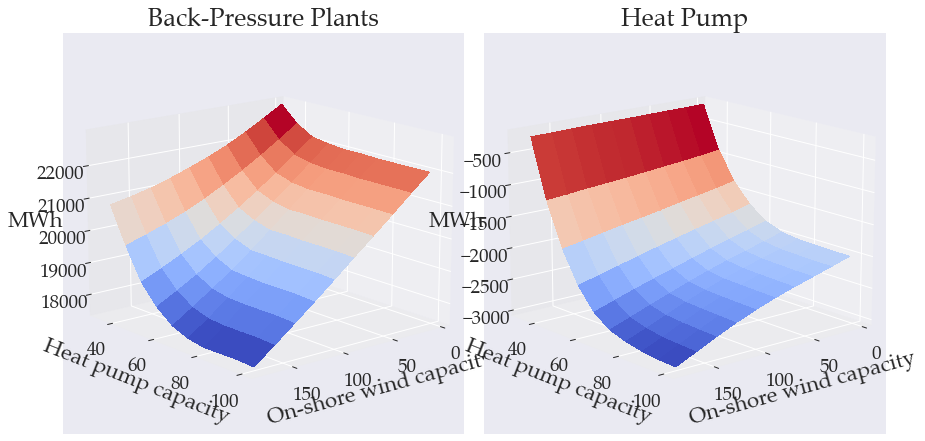

In [25]:
%%capture
BP_id = mBasicPH.getTechs(['BP'],db)
HP_id = mBasicPH.getTechs(['HP'],db)
v1, v2 = solution['Generation_E'][solution['Generation_E'].index.get_level_values('id').isin(BP_id)].xs('g1').groupby(['loop']).agg('sum'), solution['Generation_E'][solution['Generation_E'].index.get_level_values('id').isin(HP_id)].xs('g1').groupby(['loop']).agg('sum')
v1.index, v2.index =  pd.MultiIndex.from_tuples(v1.index.array).rename(['HCap','ECap']), pd.MultiIndex.from_tuples(v2.index.array).rename(['HCap','ECap'])
v1 = v1.rename({x:y for x,y in zip(grid_HCap.index.get_level_values('l1'),grid_HCap.values)},level='HCap').rename({x:y for x,y in zip(grid_ECap.index.get_level_values('l2'),grid_ECap.values)},level='ECap')
v2 = v2.rename({x:y for x,y in zip(grid_HCap.index.get_level_values('l1'),grid_HCap.values)},level='HCap').rename({x:y for x,y in zip(grid_ECap.index.get_level_values('l2'),grid_ECap.values)},level='ECap')
fig, axes = plt.subplots(1,2, subplot_kw={"projection": "3d"},figsize=(12,8));
ax = plt.subplot(1, 2, 1);
(X,Y),Z= np.meshgrid(grid_HCap.values,grid_ECap.values), v1.unstack('ECap').astype(float)
surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm,linewidth=0, antialiased=False)
ax.view_init(15,50);
ax.set_xlabel('On-shore wind capacity', labelpad = 10);
ax.set_ylabel('Heat pump capacity', labelpad = 10);
ax.set_zlabel('MWh',labelpad=10);
ax.set_title('Back-Pressure Plants');
ax = plt.subplot(1, 2, 2);
(X,Y),Z= np.meshgrid(grid_HCap.values,grid_ECap.values), v2.unstack('ECap').astype(float)
surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm,linewidth=0, antialiased=False)
ax.view_init(15,50);
ax.set_xlabel('On-shore wind capacity', labelpad = 10);
ax.set_ylabel('Heat pump capacity', labelpad = 10);
ax.set_zlabel('MWh',labelpad=10);
ax.set_title('Heat Pump');
fig.tight_layout();

Draw heat generation:

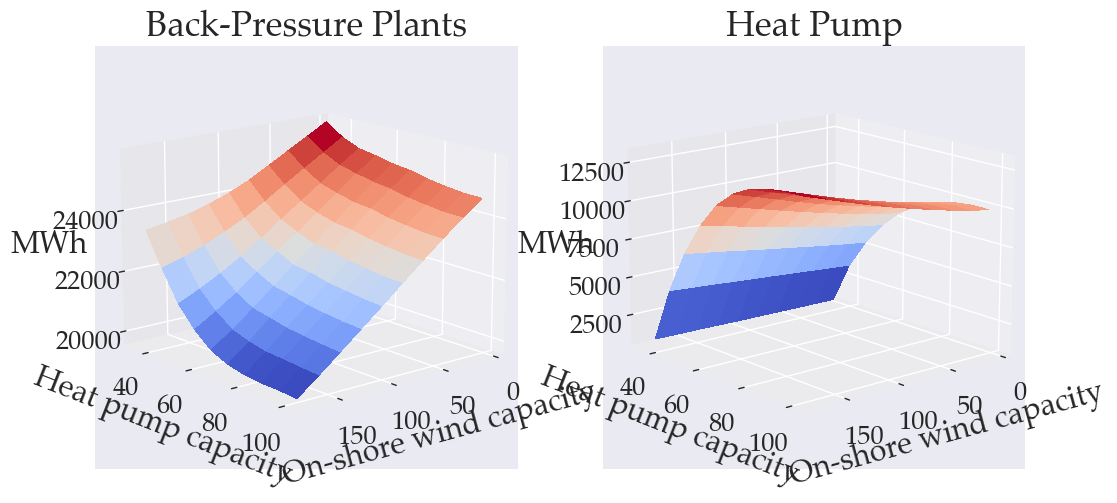

In [30]:
%%capture
v1, v2 = solution['Generation_H'][solution['Generation_H'].index.get_level_values('id').isin(BP_id)].xs('g1').groupby(['loop']).agg('sum'), solution['Generation_H'][solution['Generation_H'].index.get_level_values('id').isin(HP_id)].xs('g1').groupby(['loop']).agg('sum')
v1.index, v2.index =  pd.MultiIndex.from_tuples(v1.index.array).rename(['HCap','ECap']), pd.MultiIndex.from_tuples(v2.index.array).rename(['HCap','ECap'])
v1 = v1.rename({x:y for x,y in zip(grid_HCap.index.get_level_values('l1'),grid_HCap.values)},level='HCap').rename({x:y for x,y in zip(grid_ECap.index.get_level_values('l2'),grid_ECap.values)},level='ECap')
v2 = v2.rename({x:y for x,y in zip(grid_HCap.index.get_level_values('l1'),grid_HCap.values)},level='HCap').rename({x:y for x,y in zip(grid_ECap.index.get_level_values('l2'),grid_ECap.values)},level='ECap')
fig, axes = plt.subplots(1,2, subplot_kw={"projection": "3d"},figsize=(12,8));
ax = plt.subplot(1, 2, 1);
(X,Y),Z= np.meshgrid(grid_HCap.values,grid_ECap.values), v1.unstack('ECap').astype(float)
surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm,linewidth=0, antialiased=False)
ax.view_init(15,50);
ax.set_xlabel('On-shore wind capacity', labelpad = 10);
ax.set_ylabel('Heat pump capacity', labelpad = 10);
ax.set_zlabel('MWh',labelpad=10);
ax.set_title('Back-Pressure Plants');
ax = plt.subplot(1, 2, 2);
(X,Y),Z= np.meshgrid(grid_HCap.values,grid_ECap.values), v2.unstack('ECap').astype(float)
surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm,linewidth=0, antialiased=False)
ax.view_init(15,50);
ax.set_xlabel('On-shore wind capacity', labelpad = 10);
ax.set_ylabel('Heat pump capacity', labelpad = 10);
ax.set_zlabel('MWh',labelpad=10);
ax.set_title('Heat Pump');
# fig.tight_layout();

Now draw prices

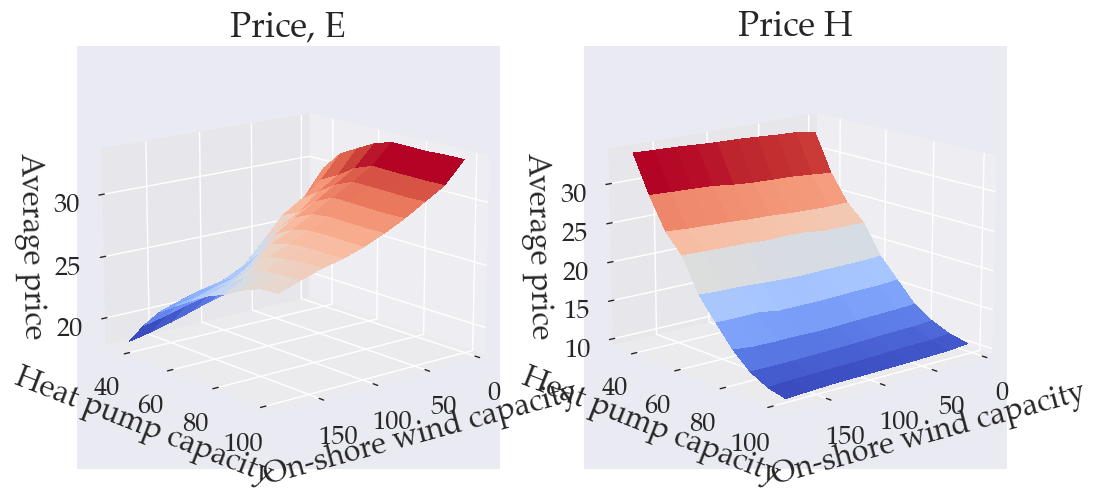

In [31]:
%%capture
v1, v2 = solution['meanConsumerPrice_E'].xs('g1'), solution['meanConsumerPrice_H'].xs('g1')
v1.index, v2.index =  pd.MultiIndex.from_tuples(v1.index.array).rename(['HCap','ECap']), pd.MultiIndex.from_tuples(v2.index.array).rename(['HCap','ECap'])
v1 = v1.rename({x:y for x,y in zip(grid_HCap.index.get_level_values('l1'),grid_HCap.values)},level='HCap').rename({x:y for x,y in zip(grid_ECap.index.get_level_values('l2'),grid_ECap.values)},level='ECap')
v2 = v2.rename({x:y for x,y in zip(grid_HCap.index.get_level_values('l1'),grid_HCap.values)},level='HCap').rename({x:y for x,y in zip(grid_ECap.index.get_level_values('l2'),grid_ECap.values)},level='ECap')
fig, axes = plt.subplots(1,2, subplot_kw={"projection": "3d"},figsize=(12,8));
ax = plt.subplot(1, 2, 1);
(X,Y),Z= np.meshgrid(grid_HCap.values,grid_ECap.values), v1.unstack('ECap').astype(float)
surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm,linewidth=0, antialiased=False)
ax.view_init(15,50);
ax.set_xlabel('On-shore wind capacity', labelpad = 10);
ax.set_ylabel('Heat pump capacity', labelpad = 10);
ax.set_zlabel('Average price',labelpad=10);
ax.set_title('Price, E');
ax = plt.subplot(1, 2, 2);
(X,Y),Z= np.meshgrid(grid_HCap.values,grid_ECap.values), v2.unstack('ECap').astype(float)
surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm,linewidth=0, antialiased=False)
ax.view_init(15,50);
ax.set_xlabel('On-shore wind capacity', labelpad = 10);
ax.set_ylabel('Heat pump capacity', labelpad = 10);
ax.set_zlabel('Average price',labelpad=10);
ax.set_title('Price H');
# fig.tight_layout();